HEART DISEASE PREDICTION ACROSS UNITED STATES FUCK


In [1]:
# describe df here

# using demgraphics and clinical data to predict heart disease

Mounted at /content/drive


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn

from sklearn.preprocessing import StandardScaler, RobustScaler

from sklearn.neighbors import KNeighborsClassifier

from sklearn.naive_bayes import GaussianNB

from sklearn.tree import DecisionTreeClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

from lightgbm import LGBMClassifier

from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, cross_validate
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve, average_precision_score, auc

from imblearn.over_sampling import SMOTE

from sklearn.feature_selection import SelectFromModel

1. FILE LOADING

In [ ]:
# RUN THIS INSTEAD IF FILE IS UPLOADED ON SESSION STORAGE

df = pd.read_csv('HEART_DISEASE_INDICATORS_2022.csv')
df.info()

In [3]:
# RUN THIS IF FILE IS UPLOADED ON CLOUD

from google.colab import drive
drive.mount('/content/drive')

path_to_file = '/content/drive/My Drive/projectwork/' # SET FILE PATH HERE
df = pd.read_csv(path_to_file + 'HEART_DISEASE_INDICATORS_2022.csv')
df.info()

Mounted at /content/drive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445132 entries, 0 to 445131
Data columns (total 40 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   State                      445132 non-null  object 
 1   Sex                        445132 non-null  object 
 2   GeneralHealth              443934 non-null  object 
 3   PhysicalHealthDays         434205 non-null  float64
 4   MentalHealthDays           436065 non-null  float64
 5   LastCheckupTime            436824 non-null  object 
 6   PhysicalActivities         444039 non-null  object 
 7   SleepHours                 439679 non-null  float64
 8   RemovedTeeth               433772 non-null  object 
 9   HadHeartAttack             442067 non-null  object 
 10  HadAngina                  440727 non-null  object 
 11  HadStroke                  443575 non-null  object 
 12  HadAsthma                  443359 non-null  object 
 13  Had

2. EDA

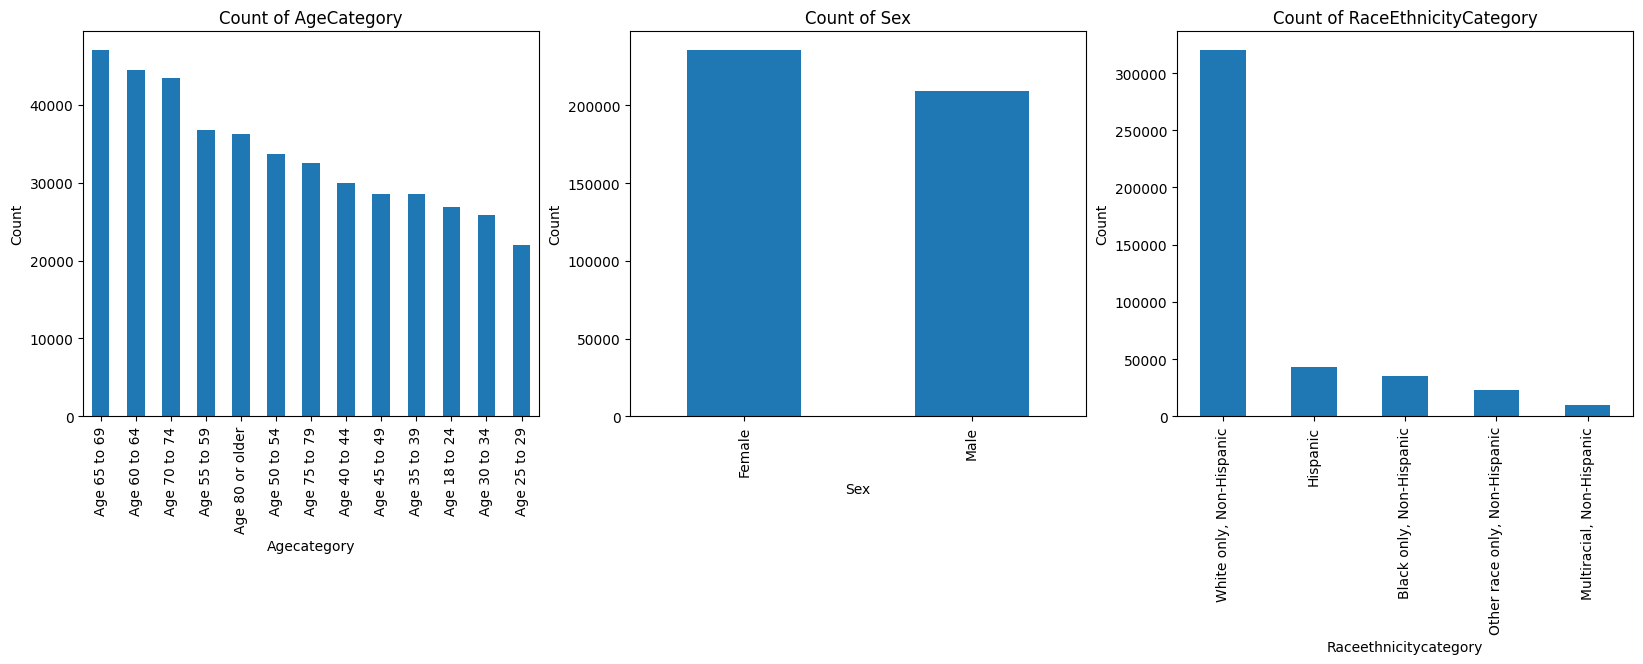

In [4]:
# DISTRIBUTION ACCORDING TO AGE, GENDER & ETHNICITY

fig, axs = plt.subplots(1, 3, figsize=(20, 5))

columns_to_plot = ['AgeCategory', 'Sex','RaceEthnicityCategory']

# Plot each column's values and their counts
for i, column in enumerate(columns_to_plot):
    counts = df[column].value_counts()
    counts.plot(kind='bar', ax=axs[i])
    axs[i].set_title(f'Count of {column}')
    axs[i].set_xlabel(column.capitalize())
    axs[i].set_ylabel('Count')

3. Data Preprocessing

In [5]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 246022 entries, 342 to 445130
Data columns (total 40 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   State                      246022 non-null  object 
 1   Sex                        246022 non-null  object 
 2   GeneralHealth              246022 non-null  object 
 3   PhysicalHealthDays         246022 non-null  float64
 4   MentalHealthDays           246022 non-null  float64
 5   LastCheckupTime            246022 non-null  object 
 6   PhysicalActivities         246022 non-null  object 
 7   SleepHours                 246022 non-null  float64
 8   RemovedTeeth               246022 non-null  object 
 9   HadHeartAttack             246022 non-null  object 
 10  HadAngina                  246022 non-null  object 
 11  HadStroke                  246022 non-null  object 
 12  HadAsthma                  246022 non-null  object 
 13  HadSkinCancer              24602

In [6]:
df['HighRiskLastYear'].value_counts()

# ordinal map - removedteeth, genhealth, age category, receethinic, diabetes, somkstat, ecig, tetanus

HighRiskLastYear
No     235446
Yes     10576
Name: count, dtype: int64

In [7]:
#binary conversions

df['Sex'] = (df['Sex']=='Male').astype(int)
df['CovidPos'] = (df['CovidPos']!='No').astype(int)

yes_no_list=['PhysicalActivities','HadHeartAttack', 'HadAngina', 'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD',
             'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty',
             'DifficultyConcentrating', 'DifficultyWalking', 'DifficultyDressingBathing', 'DifficultyErrands','ChestScan',
             'AlcoholDrinkers','AlcoholDrinkers', 'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver', 'HighRiskLastYear']

for i in yes_no_list:
    df[i] = (df[i]=='Yes').astype(int)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 246022 entries, 342 to 445130
Data columns (total 40 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   State                      246022 non-null  object 
 1   Sex                        246022 non-null  int64  
 2   GeneralHealth              246022 non-null  object 
 3   PhysicalHealthDays         246022 non-null  float64
 4   MentalHealthDays           246022 non-null  float64
 5   LastCheckupTime            246022 non-null  object 
 6   PhysicalActivities         246022 non-null  int64  
 7   SleepHours                 246022 non-null  float64
 8   RemovedTeeth               246022 non-null  object 
 9   HadHeartAttack             246022 non-null  int64  
 10  HadAngina                  246022 non-null  int64  
 11  HadStroke                  246022 non-null  int64  
 12  HadAsthma                  246022 non-null  int64  
 13  HadSkinCancer              24602

In [9]:
#ordinal mapping

map1 = {'Poor':0, 'Fair':1, 'Good':2, 'Very good':3, 'Excellent':4}
df['GeneralHealth'] = df['GeneralHealth'].map(map1)

map2 = {'None of them':0, '1 to 5':1, '6 or more, but not all':2, 'All':3}
df['RemovedTeeth'] = df['RemovedTeeth'].map(map2)

map3 = {'No':0, 'Yes':2, 'No, pre-diabetes or borderline diabetes':1, 'Yes, but only during pregnancy (female)':0}
df['HadDiabetes'] = df['HadDiabetes'].map(map3)

map4 = {'Never smoked':0, 'Former smoker':1, 'Current smoker - now smokes every day':3, 'Current smoker - now smokes some days':2}
df['SmokerStatus'] = df['SmokerStatus'].map(map4)

map5 = {'Never used e-cigarettes in my entire life':0, 'Not at all (right now)':1, 'Use them some days':2,'Use them every day':3}
df['ECigaretteUsage'] = df['ECigaretteUsage'].map(map5)

map6 = {'Age 65 to 69':13, 'Age 60 to 64':12, 'Age 70 to 74':11, 'Age 55 to 59':10, 'Age 50 to 54':9, 'Age 75 to 79':8, 'Age 80 or older':7,
        'Age 40 to 44':6, 'Age 45 to 49':5, 'Age 35 to 39':4, 'Age 30 to 34':3, 'Age 18 to 24':2, 'Age 25 to 29':1}
df['AgeCategory'] = df['AgeCategory'].map(map6)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 246022 entries, 342 to 445130
Data columns (total 40 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   State                      246022 non-null  object 
 1   Sex                        246022 non-null  int64  
 2   GeneralHealth              246022 non-null  int64  
 3   PhysicalHealthDays         246022 non-null  float64
 4   MentalHealthDays           246022 non-null  float64
 5   LastCheckupTime            246022 non-null  object 
 6   PhysicalActivities         246022 non-null  int64  
 7   SleepHours                 246022 non-null  float64
 8   RemovedTeeth               246022 non-null  int64  
 9   HadHeartAttack             246022 non-null  int64  
 10  HadAngina                  246022 non-null  int64  
 11  HadStroke                  246022 non-null  int64  
 12  HadAsthma                  246022 non-null  int64  
 13  HadSkinCancer              24602

In [11]:
# one-hot encoding
list_for_onehot = ['LastCheckupTime', 'State', 'RaceEthnicityCategory', 'TetanusLast10Tdap']
df = pd.get_dummies(df, columns = list_for_onehot)

# converting bool to int
tf_map = {False:0, True:1}
cols_to_encode = [x for x in range(36,103)]

for col_idx in cols_to_encode:
    df.iloc[:, col_idx] = df.iloc[:, col_idx].map(tf_map)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 246022 entries, 342 to 445130
Columns: 103 entries, Sex to TetanusLast10Tdap_Yes, received tetanus shot, but not Tdap
dtypes: float64(6), int64(97)
memory usage: 195.2 MB


In [12]:
# EXTRA CODE - FOR CODER AID (NO NEED TO RUN FOR PREPROCESSING)
# ALSO INCLUDES df['column_name'].value_counts(), df['column_name'].isna().sum)

for x in range(len(df.columns)):
    print(x,' ',df.columns[x])

0   Sex
1   GeneralHealth
2   PhysicalHealthDays
3   MentalHealthDays
4   PhysicalActivities
5   SleepHours
6   RemovedTeeth
7   HadHeartAttack
8   HadAngina
9   HadStroke
10   HadAsthma
11   HadSkinCancer
12   HadCOPD
13   HadDepressiveDisorder
14   HadKidneyDisease
15   HadArthritis
16   HadDiabetes
17   DeafOrHardOfHearing
18   BlindOrVisionDifficulty
19   DifficultyConcentrating
20   DifficultyWalking
21   DifficultyDressingBathing
22   DifficultyErrands
23   SmokerStatus
24   ECigaretteUsage
25   ChestScan
26   AgeCategory
27   HeightInMeters
28   WeightInKilograms
29   BMI
30   AlcoholDrinkers
31   HIVTesting
32   FluVaxLast12
33   PneumoVaxEver
34   HighRiskLastYear
35   CovidPos
36   LastCheckupTime_5 or more years ago
37   LastCheckupTime_Within past 2 years (1 year but less than 2 years ago)
38   LastCheckupTime_Within past 5 years (2 years but less than 5 years ago)
39   LastCheckupTime_Within past year (anytime less than 12 months ago)
40   State_Alabama
41   State_Alaska
4

4. DATASET SELECTION

In [13]:
# WE CONSIDER 2 DATAFRAME FOR PREDICTIONs - ONE WITHOUT OTHER TARGET VARIABLES, ONE WITH ALL TARGET VARIABLES (USING OTHER TARGET VARIABLES AS PREDICTORS)

#df_WOP = df without other predictors

df_WOP = df.drop(columns=['HadAngina', 'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD',
                          'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis', 'HadDiabetes'])


# predictors and target division

X1 = df.loc[:,df.columns!='HadHeartAttack'].values
y1 = df.loc[:,'HadHeartAttack'].values

X2 = df_WOP.loc[:,df_WOP.columns!='HadHeartAttack'].values
y2 = df_WOP.loc[:,'HadHeartAttack'].values

Target Variable Division:

HadHeartAttack
0    232587
1     13435
Name: count, dtype: int64



<Axes: ylabel='count'>

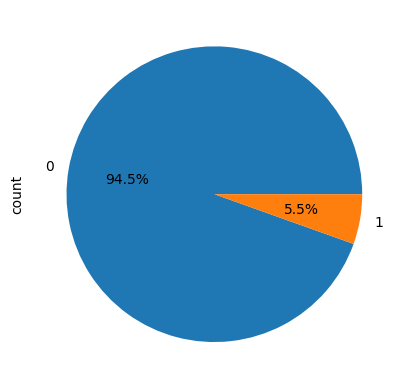

In [14]:
print('Target Variable Division:\n')
print(df['HadHeartAttack'].value_counts(),end='\n\n')

# Assuming 'binary_column' is the name of your binary-valued column
df['HadHeartAttack'].value_counts().plot(kind='pie', autopct='%1.1f%%')


5. Classification and Results


In [15]:
#APPLYING SMOTE

smote = SMOTE(random_state=42) #50 50

# Resample the dataset
X1_resampled, y1_resampled = smote.fit_resample(X1, y1)
X2_resampled, y2_resampled = smote.fit_resample(X2, y2)


(465174, 102)

In [16]:
# MODEL INITIALIZATION (DO NOT RUN ON KNN, RF, GBMs BECUZ IS TAKES A LOT OF TIME- USE GNB,DT,LR only)

# Tree Based Classifiers

# decision trees
DT = DecisionTreeClassifier(
        criterion='gini',     # Split criterion ('gini' or 'entropy')
        max_depth=None,       # Maximum depth of the tree
        min_samples_split=2,  # Minimum number of samples required to split an internal node
        min_samples_leaf=1,   # Minimum number of samples required to be at a leaf node
        random_state=42)

# logistic regression
LR = sklearn.linear_model.LogisticRegression()

# gaussian naive bayes
GNB = GaussianNB()


In [17]:
# RESULTS FOR Dataset1 (with all predictors)

print('FOR Dataset 1: With All Predictor Variables\n\n')

# set variables here
X = X1_resampled
y = y1_resampled

def calculate_all(model, X, y, k=5):
    kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    aupr_scores = []

    scoring = ['accuracy', 'f1', 'roc_auc', 'average_precision','precision','recall']

    for train_index, val_index in kf.split(X, y):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        model.fit(X_train, y_train)
        y_val_pred_proba = model.predict_proba(X_val)[:, 1] # Assuming binary classification

        precision, recall, _ = precision_recall_curve(y_val, y_val_pred_proba)
        aupr = auc(recall, precision)
        aupr_scores.append(aupr)

    result = list()
    scores = cross_validate(model, X, y, cv=kf, scoring=scoring)

    return scores, aupr_scores

# invoking function
models = [GNB,LR,DT]

for model in models:
    results = calculate_all(model, X, y)
    scores = results[0]
    aupr_list = results[1]

    # mean and standard deviations over all folds
    print(f'Classifier: {model}' )

    aupr_mean = np.mean(aupr_list)
    aupr_std = np.std(aupr_list)

    for value in scores:
        v = str(value)
        mean_score = scores[v].mean()
        std_score = scores[v].std()
        if (v == "fit_time" or v =="score_time"):
            pass
        else:
            print(f"{v.capitalize()} - Mean: {mean_score:.2f} ± {std_score:.2f}")

    print(f"AUPR: {aupr_mean:.2f} ± {aupr_std:.2f}\n")

FOR Dataset 1: With All Predictor Variables


Classifier: GaussianNB()
Test_accuracy - Mean: 0.77 ± 0.00
Test_f1 - Mean: 0.79 ± 0.00
Test_roc_auc - Mean: 0.85 ± 0.00
Test_average_precision - Mean: 0.84 ± 0.00
Test_precision - Mean: 0.73 ± 0.00
Test_recall - Mean: 0.86 ± 0.00
AUPR: 0.84 ± 0.00



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Classifier: LogisticRegression()
Test_accuracy - Mean: 0.82 ± 0.00
Test_f1 - Mean: 0.82 ± 0.00
Test_roc_auc - Mean: 0.91 ± 0.00
Test_average_precision - Mean: 0.89 ± 0.00
Test_precision - Mean: 0.85 ± 0.00
Test_recall - Mean: 0.78 ± 0.00
AUPR: 0.89 ± 0.00

Classifier: DecisionTreeClassifier(random_state=42)
Test_accuracy - Mean: 0.96 ± 0.00
Test_f1 - Mean: 0.96 ± 0.00
Test_roc_auc - Mean: 0.96 ± 0.00
Test_average_precision - Mean: 0.93 ± 0.00
Test_precision - Mean: 0.95 ± 0.00
Test_recall - Mean: 0.96 ± 0.00
AUPR: 0.97 ± 0.00



In [18]:
# RESULTS FOR Dataset2 (without all predictors)

print('FOR Dataset2: Without using Target Variables as Predictors\n\n')

# set variables here
X = X2_resampled
y = y2_resampled

def calculate_all(model, X, y, k=5):
    kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    aupr_scores = []

    scoring = ['accuracy', 'f1', 'roc_auc', 'average_precision','precision','recall']

    for train_index, val_index in kf.split(X, y):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        model.fit(X_train, y_train)
        y_val_pred_proba = model.predict_proba(X_val)[:, 1] # Assuming binary classification

        precision, recall, _ = precision_recall_curve(y_val, y_val_pred_proba)
        aupr = auc(recall, precision)
        aupr_scores.append(aupr)

    result = list()
    scores = cross_validate(model, X, y, cv=kf, scoring=scoring)

    return scores, aupr_scores

# invoking function
models = [GNB,LR,DT]

for model in models:
    results = calculate_all(model, X, y)
    scores = results[0]
    aupr_list = results[1]

    # mean and standard deviations over all folds
    print(f'Classifier: {model}' )

    aupr_mean = np.mean(aupr_list)
    aupr_std = np.std(aupr_list)

    for value in scores:
        v = str(value)
        mean_score = scores[v].mean()
        std_score = scores[v].std()
        if (v == "fit_time" or v =="score_time"):
            pass
        else:
            print(f"{v.capitalize()} - Mean: {mean_score:.2f} ± {std_score:.2f}")

    print(f"AUPR: {aupr_mean:.2f} ± {aupr_std:.2f}\n")

FOR Dataset2: Without using Target Variables as Predictors


Classifier: GaussianNB()
Test_accuracy - Mean: 0.72 ± 0.00
Test_f1 - Mean: 0.74 ± 0.00
Test_roc_auc - Mean: 0.79 ± 0.00
Test_average_precision - Mean: 0.76 ± 0.00
Test_precision - Mean: 0.68 ± 0.00
Test_recall - Mean: 0.82 ± 0.00
AUPR: 0.76 ± 0.00



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Classifier: LogisticRegression()
Test_accuracy - Mean: 0.76 ± 0.00
Test_f1 - Mean: 0.77 ± 0.00
Test_roc_auc - Mean: 0.84 ± 0.00
Test_average_precision - Mean: 0.79 ± 0.00
Test_precision - Mean: 0.75 ± 0.00
Test_recall - Mean: 0.79 ± 0.00
AUPR: 0.79 ± 0.00

Classifier: DecisionTreeClassifier(random_state=42)
Test_accuracy - Mean: 0.95 ± 0.00
Test_f1 - Mean: 0.95 ± 0.00
Test_roc_auc - Mean: 0.95 ± 0.00
Test_average_precision - Mean: 0.92 ± 0.00
Test_precision - Mean: 0.94 ± 0.00
Test_recall - Mean: 0.95 ± 0.00
AUPR: 0.96 ± 0.00

